In [5]:
import os
import numpy as np
from osgeo import gdal
from tensorflow import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

Populating the interactive namespace from numpy and matplotlib


In [6]:
BASE_PATH = "."
IMAGE_PATH = os.path.join(BASE_PATH, "raw_images")
LABEL_PATH = os.path.join(BASE_PATH, "ground_truth")

In [7]:
def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.
    
    The following keys are used:
    sat -- satellite image
    bldg -- for the building locations reference image
    road -- for the road locations reference image
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        fname, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = fname
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles


def visualize_labels(labels, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Other", "Informal Settlements"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:-1]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

image_tiles = fetch_tiles(IMAGE_PATH)
label_tiles = fetch_tiles(LABEL_PATH)

# visualize_data(image_tiles["area1"], "Sample training image tile 1")
# visualize_labels(label_tiles["area1"])

In [8]:
label_tiles.keys()

dict_keys(['align_crop_2020', 'gt_test_1', 'gt_train_1', 'gt_train_2', 'gt_train_3', 'gt_valid_1'])

In [9]:
PATCHSIZE = 128
NBANDS = image_tiles["tile_train_1"].shape[-1]


def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.nan_to_num(tocat, nan=np.nanmedian(tocat))
            tocat[tocat < -1] = np.median(tocat)
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples


Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas_x = ["tile_train_1", "tile_train_2", "tile_train_3",]
train_areas_y = ["gt_train_1", "gt_train_2", "gt_train_3"]

for area in range(len(train_areas_x)):
    X_toadd = gridwise_sample(image_tiles[train_areas_x[area]], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[train_areas_y[area]], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
# Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 1368 number of training patches


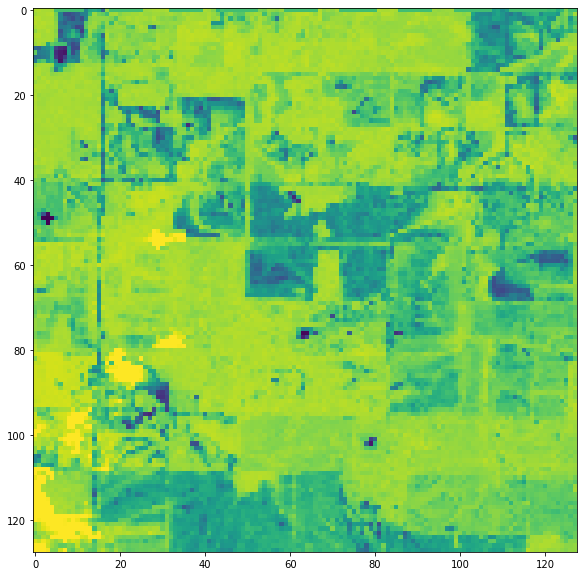

In [10]:
plt.imshow(Xtrain[10, :, :, 4])

In [11]:
Xvalid = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Yvalid = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas_x = ["tile_valid_1"]
train_areas_y = ["gt_valid_1"]

for area in range(len(train_areas_x)):
    X_toadd = gridwise_sample(image_tiles[train_areas_x[area]], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[train_areas_y[area]], PATCHSIZE)
    Xvalid = np.concatenate((Xvalid, X_toadd), axis=0)
    Yvalid = np.concatenate((Yvalid, Y_toadd), axis=0)
# encode all non-informal settlement classes as one class
# Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xvalid.shape[0]))

There are 456 number of training patches


In [12]:
image_tiles["tile_train_1"].shape

(1122, 7420, 8)

In [12]:
from sklearn.ensemble import RandomForestClassifier

Xtrain_rf = Xtrain.reshape(-1, 8)
ytrain_rf = Ytrain.flatten()
Xvalid_rf = Xvalid.reshape(-1, 8)
yvalid_rf = Yvalid.flatten()

In [13]:
Xtrain_rf.shape

(22413312, 8)

In [15]:
from collections import Counter

c = Counter(ytrain_rf)

In [16]:
f = {x:c[x]/sum(list(c.values())) for x in c}

In [40]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1,max_samples=100000, verbose=1 ,class_weight=f, oob_score=True)

In [15]:
f

{5: 0.4561831825657895,
 1: 0.16186916061312134,
 4: 0.2679986340260645,
 3: 0.03105658815618147,
 2: 0.0828924346388432}

In [25]:
c.keys()

dict_keys([5, 1, 4, 3, 2])

In [16]:
import seaborn as sns
sns.set()

Feature: 0, Score: 0.14007
Feature: 1, Score: 0.15843
Feature: 2, Score: 0.12859
Feature: 3, Score: 0.11323
Feature: 4, Score: 0.13420
Feature: 5, Score: 0.12622
Feature: 6, Score: 0.10418
Feature: 7, Score: 0.09508


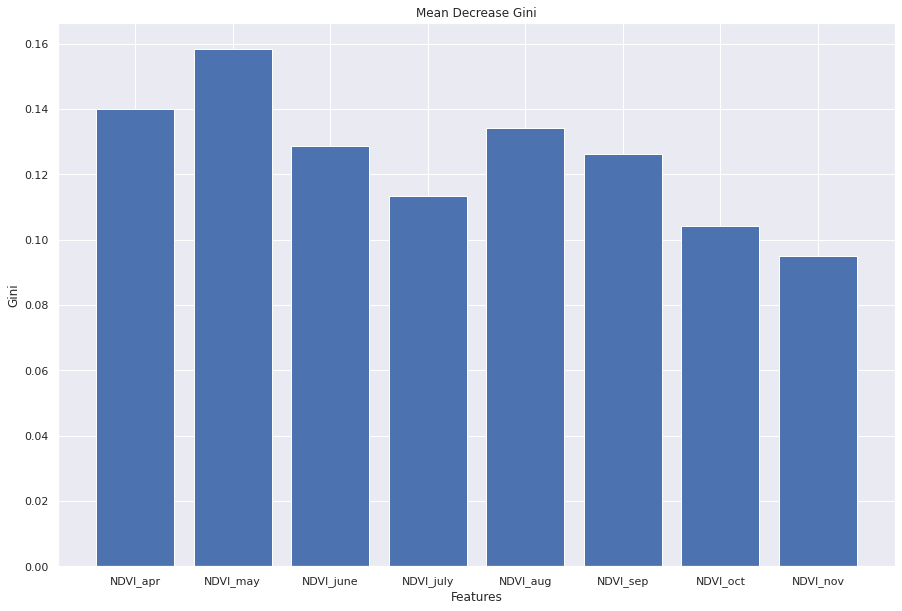

In [21]:
importance = rf.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(8), ["NDVI_apr", "NDVI_may", "NDVI_june", "NDVI_july", "NDVI_aug", "NDVI_sep", "NDVI_oct", "NDVI_nov"])
plt.title("Mean Decrease Gini")
plt.ylabel("Gini")
plt.xlabel("Features")
plt.savefig("ginidec.png", dpi=300)
plt.show()

In [31]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(Xtrain_rf,ytrain_rf, train_size=100000, random_state=42, stratify=ytrain_rf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


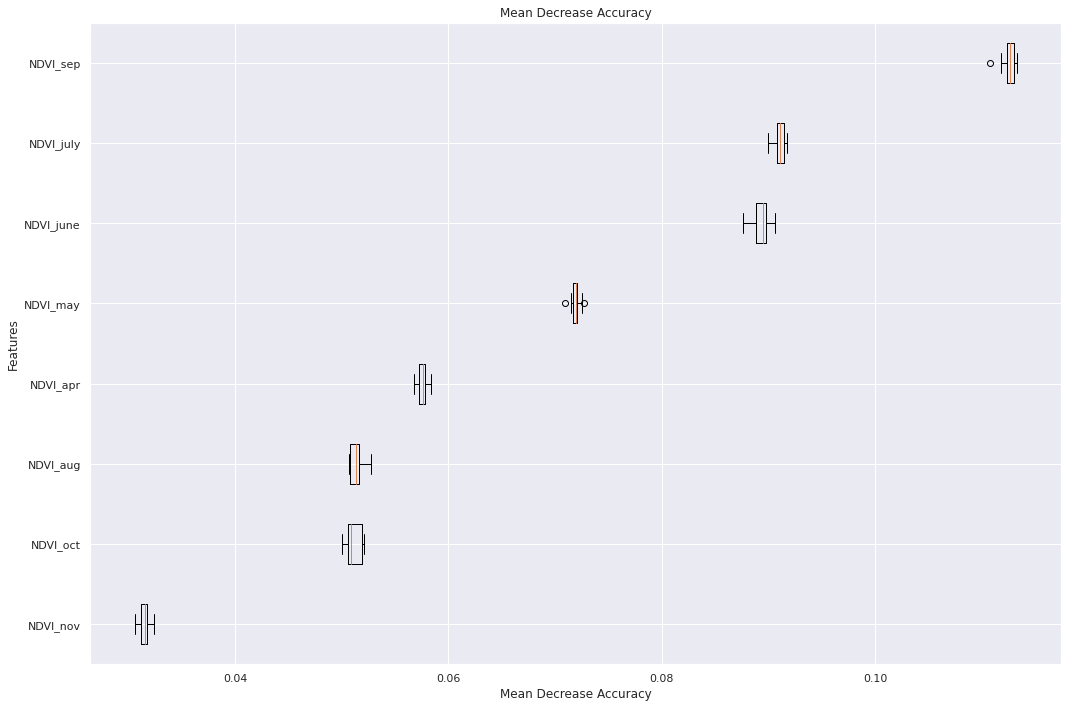

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_job

In [43]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
lab = np.array(["NDVI_apr", "NDVI_may", "NDVI_june", "NDVI_july", "NDVI_aug", "NDVI_sep", "NDVI_oct", "NDVI_nov"])
fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=lab[sorted_idx]
)
ax.set_title("Mean Decrease Accuracy")
plt.xlabel("Mean Decrease Accuracy")
plt.ylabel("Features")
fig.tight_layout()
plt.savefig("mda.png", dpi=300)
plt.show()

In [32]:
rf.fit(Xtrain_rf, ytrain_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished


RandomForestClassifier(class_weight={1: 0.16337985744724026,
                                     2: 0.11581381265219155,
                                     3: 0.04209238027597403,
                                     4: 0.30778919566761365,
                                     5: 0.37092475395698055},
                       max_samples=100000, n_jobs=-1, verbose=1)

In [17]:
import rasterio
av = rasterio.open("./raw_images/Final_merge_2020_ndvi.tif").read()
avgt = rasterio.open("./ground_truth/align_crop_2020.tif").read()

In [38]:
from sklearn.metrics import accuracy_score
#accuracy_score(rf.predict(Xvalid_rf), yvalid_rf)

In [39]:
accuracy_score(rf.predict(Xtrain_rf), ytrain_rf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished


0.8618556240148711

In [20]:
from sklearn.metrics import confusion_matrix

f = rf.predict(Xvalid_rf)
cm = confusion_matrix(yvalid_rf, f)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   27.2s finished


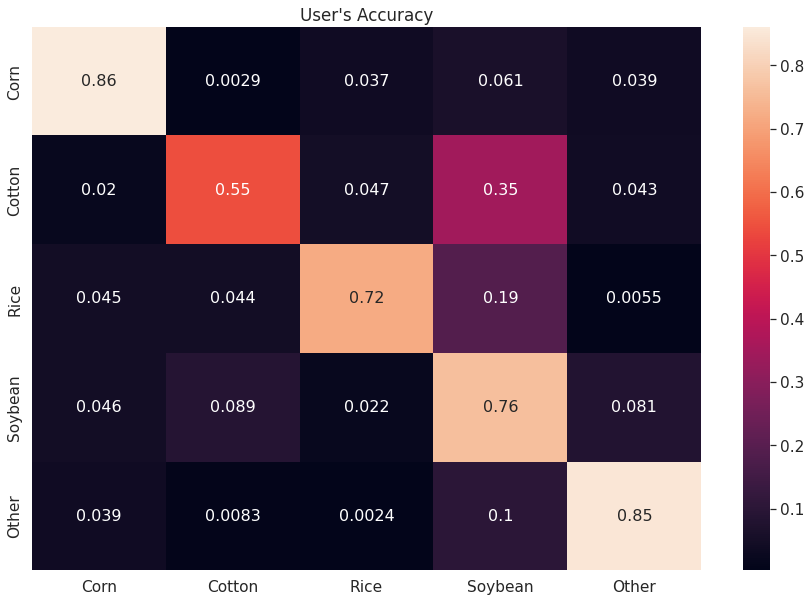

In [33]:
import seaborn as sns
import pandas as pd
sns.set()
#a = confusion_matrix(yvalid_rf, f)
cm2 = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]

df_cm = pd.DataFrame(cm2, range(5), range(5))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},
 xticklabels=['Corn', 'Cotton', 'Rice','Soybean', 'Other'],
 yticklabels=['Corn', 'Cotton', 'Rice','Soybean', 'Other']) # font size
plt.title("User's Accuracy")
plt.savefig("user_2020.png", dpi=300)
plt.show()

In [50]:
rf.oob_score_

0.8609574970446134

In [4]:
import rasterio

a = rasterio.open("./raw_images/big_data_2020.tif")

In [5]:
b = a.read()

In [6]:
b.shape

(8, 5606, 7420)

In [7]:
c = np.zeros((5606, 7420, 8))

In [8]:
c.shape

(5606, 7420, 8)

In [9]:
for i in range(5606):
    for j in range(7420):
        c[i,j,:] = b[:, i, j]

In [10]:
c = c.reshape((-1, 8))

In [11]:
pred = np.zeros((5606*7420)).astype(np.uint8)

In [ ]:
for i in range((5606*7420)//100000):
    g = c[i*100000:(i+1)*100000,:].reshape(-1, 8)
    g = np.nan_to_num(g, nan=np.nanmedian(g))
    j = rf.predict(g)
    pred[i*100000:(i+1)*100000] = j

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_job

In [42]:
from joblib import load

rf = load('filename.joblib')

In [ ]:
gh = rf.predict(np.nan_to_num(c[np.where(pred==0),:], np.median(g)).reshape(-1, 8))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
pred[np.where(pred==0)] = gh

In [21]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import seaborn as sns
sns.set()
#cohen_kappa_score(yvalid_rf, f)

In [26]:
gt = rasterio.open("./cropland_align_2020_30m.tif")

In [16]:
gt = gt.read()

In [17]:
ff = gt.flatten()

In [18]:
np.unique(ff)

array([1, 2, 3, 4, 5], dtype=uint8)

In [19]:
np.unique(pred)

array([1, 2, 3, 4, 5], dtype=uint8)

In [55]:
accuracy_score(pred, ff)

0.735911409958687

In [22]:
accuracy_score(pred, ff)

0.7908115150017357

In [29]:
cm = confusion_matrix(pred, ff)

In [47]:
cm

array([[ 2864515,    11126,   406556,  1155548,   187589],
       [      92,        2,        1,       97,     1456],
       [     154,        0,        0,       11,       32],
       [  125727,    94908,    18020,   333841,   160511],
       [ 2226982,  3522390,  1052532, 11664530, 17769900]])

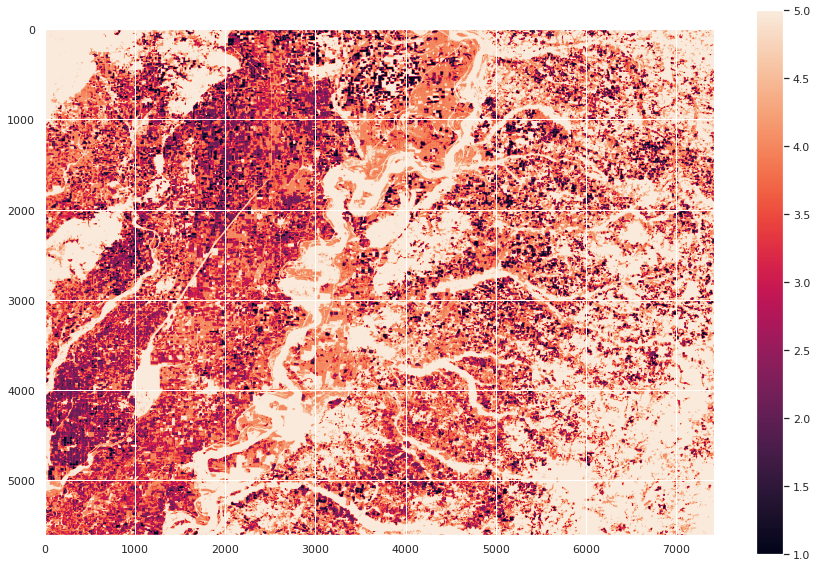

In [23]:
plt.imshow(pred.reshape(5606, 7420))
plt.colorbar()

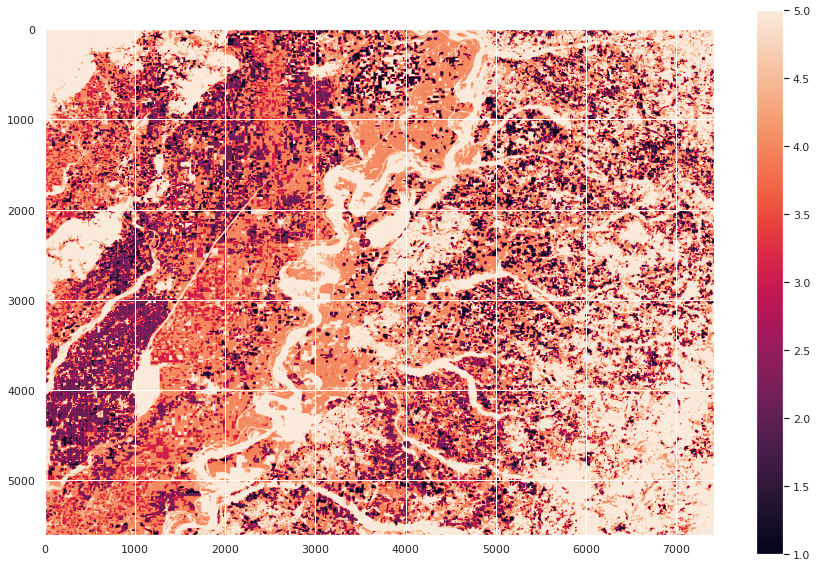

In [24]:
plt.imshow(ff.reshape(5606, 7420))
plt.colorbar()

In [27]:
dataset = rasterio.open("./pred_2020.tif","w",
                driver=gt.driver, width= 7420, height = 5606,
                transform=gt.transform, crs=gt.crs, count=1, dtype=np.uint8)

In [28]:
dataset.write(pred.reshape(1, 5606, 7420))
dataset.close()

In [ ]:
rf.fit(Xtrain_rf, ytrain_rf)